## Accuracy Score

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

# scikit learn의 Classifier 구현을 흉내 : Estimator들은 BaseEstimator를 상속받아야 GridSearchCV, cross_val_score()등 다양한 utility class들과 자연스럽게 결합이 가능함!

class MyDummyClassifier (BaseEstimator):
    # fit() method는 아무것도 학습 안하는걸로 정의
    def fit(self, X, y=None):
        pass
    # predict() method는 단순히 Sex feature가 1(남자)면 0(사망), 그렇지 않으면 1(생존)으로 예측하도록 정의
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred
            

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트 데이터 분할. 
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df= titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test=train_test_split(X_titanic_df, y_titanic_df, \
                                                  test_size=0.2, random_state=0)

위에서 생성한 Dummy Classifier를 이용하여 학습-예측-평가 수행

In [5]:
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypred = myclf.predict(X_test)
print('My Dummy Classifier의 정확도는:', accuracy_score(y_test, mypred))

My Dummy Classifier의 정확도는: 0.7877094972067039


##### 단순하게 남성은 사망, 여성은 생존으로 예측하게 만들었는데도 'accuracy'로 평가를 해보니, 정확도가 무려 78%가 나온다. (이진 분류의 경우 문제 있음)

In [6]:
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass

    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X), 1) , dtype=bool )

# 사이킷런의 내장 데이터 셋인 load_digits( )를 이용하여 MNIST 데이터 로딩 
digits = load_digits()

print(digits.data)
print("### digits.data.shape:", digits.data.shape)
print(digits.target)
print("### digits.target.shape:", digits.target.shape)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]
### digits.data.shape: (1797, 64)
[0 1 2 ... 8 9 8]
### digits.target.shape: (1797,)


In [7]:
# 현재 digit.target이 7로 되어 있는 수는?
(digits.target == 7).sum()

179

In [8]:
# digits 번호가 7이면 'True', 1로 반환 / 7이 아니면 'False', 0으로 반환
y = (digits.target == 7).astype(int)
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, y, random_state = 11)

In [9]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train , y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

레이블 테스트 세트 크기 : (179,)
테스트 세트 레이블 0 과 1의 분포도
0    110
1     69
Name: Survived, dtype: int64
모든 예측을 0으로 하여도 정확도는:0.615


이와 같이 target의 분포가 불균형한 분포를 가질 때 accuracy score가 한계가 있음을 알 수 있다. 따라서, accuracy 말고 다른 평가 지표를 알아두자. 

## Confusion Matrix

**오차행렬(confusion matrix):** 이진분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표

In [10]:
from sklearn.metrics import confusion_matrix

# 앞에서 예측한 결과인 fakepred와 실제 결과인 y_test의 Confusion Matrix출력
confusion_matrix(y_test , fakepred)

array([[110,   0],
       [ 69,   0]], dtype=int64)

## Precision(정밀도) & Recall(재현율)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print('precision(정밀도):', precision_score(y_test, fakepred))
print('recall(재현율):', recall_score(y_test, fakepred))

precision(정밀도): 0.0
recall(재현율): 0.0


C:\Users\happy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Precision/Recall Trade-off

**reminder**

Precision(정밀도) = TP / (TP+FP)

Recall(재현율) = TP / (TP+FN)

* Precision과 Recall은 상호 보완적인 평가 지표이기 때문에 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어지기 쉬움.


#### predict_proba( )

* 개별 데이터별로 예측 확률을 반환하는 method
* 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능
* test feature dataset을 parameter로 입력해주면 test feature record의 개별 클래스 예측 확률을 반환함.
* predict() method와 유사하지만, 단지 변환 결과가 예측 결과 클래스값이 아닌 예측 확률 결과라는 것. 

In [12]:
X_titanic_df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


In [13]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy , precision ,recall))

In [14]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [15]:
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[93 17]
 [20 49]]
정확도: 0.7933, 정밀도: 0.7424, 재현율: 0.7101


In [16]:
pred_probability = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

In [17]:
pred_probability.shape

(179, 2)

In [18]:
pred.shape

(179,)

In [19]:
pred_probability[:3]

array([[0.85157349, 0.14842651],
       [0.87164665, 0.12835335],
       [0.9239038 , 0.0760962 ]])

In [20]:
# 예측 확률 array와 예측 결과값 array를 병합해 예측 확률 & 결과값을 한눈에 확인
pred_probability_result = np.concatenate([pred_probability, pred.reshape(-1,1)], axis = 1)
pred_probability_result[:3]

array([[0.85157349, 0.14842651, 0.        ],
       [0.87164665, 0.12835335, 0.        ],
       [0.9239038 , 0.0760962 , 0.        ]])

이 결과가 0일 확률이 첫번째 열, 이 결과가 1일 확률이 두번째 열, 확률이 더 큰 쪽으로 결과값 생성 (0 또는 1)

**사이킷런은 분류 결정 임계값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있음**

In [21]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2],
     [2, 0, 0],
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [22]:
# Binarizer의 threshold 설정값. 분류 결정 임곗값:0.5

# pred_probability() 반환값의 두 번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer 적용
pred_probability = lr_clf.predict_proba(X_test)
pred_probability_1 = pred_probability[:,1].reshape(-1,1)

binarizer = Binarizer(threshold = 0.5).fit(pred_probability_1)
custom_predict = binarizer.transform(pred_probability_1)

In [23]:
get_clf_eval(y_test, custom_predict)

오차 행렬
[[93 17]
 [20 49]]
정확도: 0.7933, 정밀도: 0.7424, 재현율: 0.7101


이 방식이 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 정확히 같다는 것을 확인할 수 있음.

따라서 predict()가 predict_proba()에 기반함을 알 수 있음. 

이번에는 **분류결정 임계값**을 **낮추면** 평가지표가 어떻게 변하는지 관찰해보자. 

In [24]:
# threshold = 0.4

pred_probability_1 = pred_probability[:,1].reshape(-1,1)

binarizer_2 = Binarizer(threshold = 0.4).fit(pred_probability_1)
custom_predict_2 = binarizer_2.transform(pred_probability_1)

get_clf_eval(y_test, custom_predict_2)

오차 행렬
[[87 23]
 [14 55]]
정확도: 0.7933, 정밀도: 0.7051, 재현율: 0.7971


threshold를 낮춤 : 재현율 값이 올라감 : 정밀도가 떨어짐. 

분류 결정 임계값은 positive 예측값을 결정하는 확률의 기준이 되는데, 확률이 0.5가 아닌 0.4부터 positive로 예측하게 되기 때문에 임계값을 낮출수록 positive값이 많아지게 되고, positive 예측값이 많아지면 상대적으로 재현율이 높아진다. 

In [25]:
# 이번에는 임계값을 0.05씩 증가시키며 평가지표가 어떻게 변하는지 관찰
# 테스트를 수행할 모든 임계값을 리스트 객체로 저장.

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행. 
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print('-----------------')

get_eval_by_threshold(y_test, pred_probability_1, thresholds)

임계값: 0.4
오차 행렬
[[87 23]
 [14 55]]
정확도: 0.7933, 정밀도: 0.7051, 재현율: 0.7971
-----------------
임계값: 0.45
오차 행렬
[[91 19]
 [18 51]]
정확도: 0.7933, 정밀도: 0.7286, 재현율: 0.7391
-----------------
임계값: 0.5
오차 행렬
[[93 17]
 [20 49]]
정확도: 0.7933, 정밀도: 0.7424, 재현율: 0.7101
-----------------
임계값: 0.55
오차 행렬
[[98 12]
 [23 46]]
정확도: 0.8045, 정밀도: 0.7931, 재현율: 0.6667
-----------------
임계값: 0.6
오차 행렬
[[101   9]
 [ 26  43]]
정확도: 0.8045, 정밀도: 0.8269, 재현율: 0.6232
-----------------


### precision_recall_curve( )

* parameter : y_true (실제 클래스값 배열), probas_pred (positive 칼럼의 예측 확률 배열)
* 반환값 : threshold 별 precision & recall

In [26]:
from sklearn.metrics import precision_recall_curve

# label 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 셋과 label 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape:', thresholds.shape)

반환된 분류 결정 임계값 배열의 shape: (172,)


In [27]:
# 반환된 임계값 배열 행이 166건이므로 샘플로 12건 추출, 임계값은 15단계로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print(thr_index)

np.round(thresholds[thr_index], 2)

[  0  15  30  45  60  75  90 105 120 135 150 165]


array([0.04, 0.11, 0.13, 0.15, 0.18, 0.24, 0.36, 0.47, 0.61, 0.71, 0.84,
       0.93])

In [28]:
# threshold 별로 추출된 임계값에 따른 precision & recall value?
print('precision:', np.round(precisions[thr_index], 3))
print('recall:', np.round(recalls[thr_index], 3))

precision: [0.385 0.409 0.455 0.504 0.562 0.629 0.707 0.731 0.827 0.919 1.    1.   ]
recall: [1.    0.971 0.957 0.942 0.913 0.884 0.841 0.71  0.623 0.493 0.319 0.101]


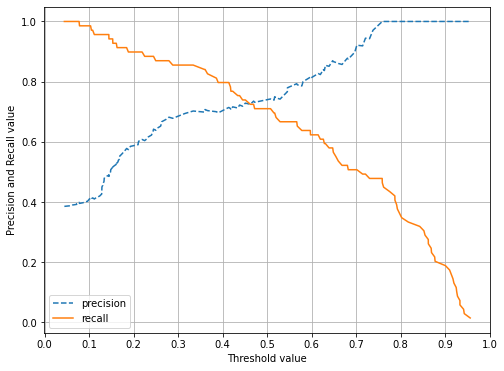

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])
    

로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우 임계값이 약 0.45인 지점에서 재현율과 정밀도가 비슷해짐.

극단적으로 정밀도가 100%가 나온다거나, 재현율이 100%가 나오는 상황이 발생해서는 안됨, 두 수치가 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가 지표가 필요함

## F1 Score

In [30]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 score:{0:.4f}'.format(f1))

F1 score:0.7259


In [31]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))

thresholds = [0.4 , 0.45 , 0.50 , 0.55 , 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차 행렬
[[87 23]
 [14 55]]
정확도: 0.7933, 정밀도: 0.7051, 재현율: 0.7971, F1:0.7483
-----------------
임계값: 0.45
오차 행렬
[[91 19]
 [18 51]]
정확도: 0.7933, 정밀도: 0.7286, 재현율: 0.7391, F1:0.7338
-----------------
임계값: 0.5
오차 행렬
[[93 17]
 [20 49]]
정확도: 0.7933, 정밀도: 0.7424, 재현율: 0.7101, F1:0.7259
-----------------
임계값: 0.55
오차 행렬
[[98 12]
 [23 46]]
정확도: 0.8045, 정밀도: 0.7931, 재현율: 0.6667, F1:0.7244
-----------------
임계값: 0.6
오차 행렬
[[101   9]
 [ 26  43]]
정확도: 0.8045, 정밀도: 0.8269, 재현율: 0.6232, F1:0.7107
-----------------


## ROC 곡선과 AUC

In [34]:
from sklearn.metrics import roc_curve

# label class = 1 일때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정되므로 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값:', np.round(thresholds[thr_index],2))


샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56 61 66]
샘플 index로 추출한 임계값: [0.96 0.7  0.64 0.61 0.53 0.47 0.43 0.36 0.25 0.18 0.16 0.13 0.11 0.04]


In [35]:
# 5 step 단위로 추출된 임계값에 따른 FPR, TPR값
print('샘플 임계값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index],3))

샘플 임계값별 FPR: [0.    0.027 0.064 0.082 0.145 0.164 0.191 0.218 0.309 0.418 0.527 0.682
 0.864 1.   ]
샘플 임계값별 TPR: [0.014 0.507 0.58  0.623 0.667 0.725 0.754 0.841 0.87  0.913 0.928 0.957
 0.971 1.   ]


임계값이 1에 가까운 값에서 점점 작아지면서

fpr 이 점점 커지고

이에 따라 tpr은 급격하게 커진다. 

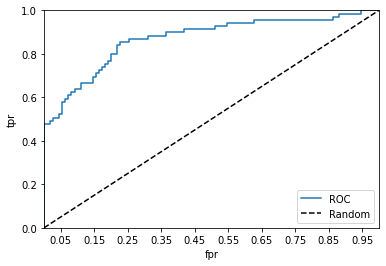

In [36]:
def roc_curve_plot(y_test, pred_proba_c1):
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    plt.plot(fprs, tprs, label = 'ROC')
    plt.plot([0,1], [0,1], 'k--', label='Random')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('fpr')
    plt.ylabel("tpr")
    plt.legend()

roc_curve_plot(y_test, pred_proba[:,1])

* AUC는 1에 가까울수록 좋음
* AUC 수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건임

In [37]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print("AUC 값:", roc_score)

AUC 값: 0.8696969696969697
